Python module to extract features from the image tiles with segmentation. The goal is to get a dataset where each row is a tile and each column is a feature

# Import

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import anndata as ad

In [2]:
from skimage import io, filters, measure, segmentation, color
from skimage import morphology
from skimage.filters import rank
import scipy.ndimage as ndi

In [3]:
from skimage.measure import regionprops

In [4]:
from sklearn.decomposition import PCA

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Input

Image tile path (jpg image), and a csv file with path of every tiles and their corresponding annotations

In [66]:
#Image 34C
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1"

In [8]:
#Image 34C pre-processed with color
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1.color2"

In [48]:
#Image 34C pre-processed with gray scale
dpath="/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1.gray2"

In [67]:
#Image 34C
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.C1.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed


In [30]:
#Image 34C pre-processed with color
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.C1.color2.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed


In [49]:
#Image 34C pre-processed with gray scale
csv_path="/disk2/user/cormey/outputs/outputs_annotated_tiles/034_RJ.C1.gray2.csv"
df_annot = pd.read_csv(csv_path)
print(df_annot.head())

                                                Path Annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed


# Output

A csv dataset where each row is a tile and each column is a feature

# Test on one image

## Segmentation with OpenCV

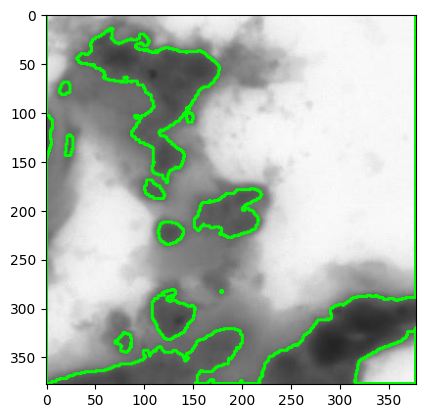

In [10]:
# Charge the pre-processed image in grayscale
image_test = cv2.imread('/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1/tissue_6_AGGCTTGCTAGACACC-1_034_RJ.C1.jpg', cv2.IMREAD_GRAYSCALE)

# Apply thresholding (100-120 seems to distinguish the best between cells)
_, thresh = cv2.threshold(image_test, 100, 120, cv2.THRESH_BINARY)

# Find outlines
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Draw outlines on the original image
segmented_image = cv2.cvtColor(image_test, cv2.COLOR_GRAY2BGR)
cv2.drawContours(segmented_image, contours, -1, (0, 255, 0), 2)

# Display the segmented image
plt.imshow(segmented_image)
plt.show()

## Segmentation with skimage

/disk2/user/cormey/environments/my_env01/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3508: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  exec(code_obj, self.user_global_ns, self.user_ns)


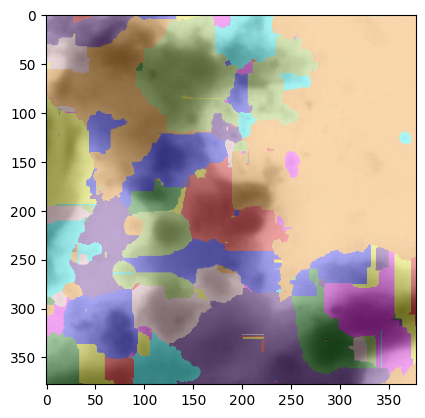

In [11]:
# Charge the pre-processed image in grayscale
image_test = io.imread('/disk2/user/cormey/outputs/Tilted_images/034_RJ.C1/tissue_6_AGGCTTGCTAGACACC-1_034_RJ.C1.jpg', as_gray=True)

# Apply a gaussian filter (only if you use non pre-processed image)
smoothed_image = filters.gaussian(image_test, sigma=1)

# Apply segmentation by watershed
markers = filters.rank.gradient(smoothed_image, morphology.disk(5)) < 10
markers = ndi.label(markers)[0]
labels = segmentation.watershed(smoothed_image, markers)

# Convert labels in RGB image
segmented_image = color.label2rgb(labels, image=image_test, bg_label=0)

# Display segmented image
plt.imshow(segmented_image)
plt.show()

## Add features of the image in a dataframe

In [8]:

# Calculate properties of segmented area
properties_test = regionprops(labels, intensity_image=image_test)

# Extract features
features_test = []
for prop in properties_test:
    features_test.append({
        'area': prop.area,
        'perimeter': prop.perimeter,
        'eccentricity': prop.eccentricity,
        'mean_intensity': prop.mean_intensity,
        'solidity': prop.solidity,
        # Add other features if necessary
    })

# display extracted features
print(features_test)

[{'area': 122.0, 'perimeter': 51.48528137423857, 'eccentricity': 0.946054297033514, 'mean_intensity': 0.6484066248794599, 'solidity': 0.9242424242424242}, {'area': 197.0, 'perimeter': 87.6923881554251, 'eccentricity': 0.9921317033282437, 'mean_intensity': 0.7691836150094554, 'solidity': 0.9036697247706422}, {'area': 118.0, 'perimeter': 59.142135623730944, 'eccentricity': 0.9735220128431312, 'mean_intensity': 0.938750601528747, 'solidity': 0.8489208633093526}, {'area': 218.0, 'perimeter': 64.79898987322333, 'eccentricity': 0.6519831863810915, 'mean_intensity': 0.9380552707321461, 'solidity': 0.8755020080321285}, {'area': 1.0, 'perimeter': 0.0, 'eccentricity': 0, 'mean_intensity': 0.9509156862745098, 'solidity': 1.0}, {'area': 4.0, 'perimeter': 2.0, 'eccentricity': 1.0, 'mean_intensity': 0.9410410784313726, 'solidity': 1.0}, {'area': 33000.0, 'perimeter': 1246.666088965482, 'eccentricity': 0.8281053028224271, 'mean_intensity': 0.9579380881639927, 'solidity': 0.7486388384754991}, {'area':

In [9]:
# Convert the list of features in DataFrame
dftest = pd.DataFrame(features_test)

# Display the DataFrame
print(dftest.head())
row, column=dftest.shape
print(row)
print(column)

    area  perimeter  eccentricity  mean_intensity  solidity
0  122.0  51.485281      0.946054        0.648407  0.924242
1  197.0  87.692388      0.992132        0.769184  0.903670
2  118.0  59.142136      0.973522        0.938751  0.848921
3  218.0  64.798990      0.651983        0.938055  0.875502
4    1.0   0.000000      0.000000        0.950916  1.000000
177
5


# Function to run segmentation on each tile

In [68]:
#Segmentation with skimage
def f_segmentation(path):
    image = io.imread(path, as_gray=True)

    # Apply a gaussian filter (only if you use non pre-processed image)
    smoothed_image = filters.gaussian(image, sigma=1)
    
    # Apply segmentation by watershed
    markers = filters.rank.gradient(smoothed_image, morphology.disk(5)) < 10
    markers = ndi.label(markers)[0]
    labels = segmentation.watershed(smoothed_image, markers)
    return labels, image

In [162]:
#Extraction of features and stockage in a dataframe
def features(labels,image):
    # Calculate properties of segmented area
    properties = regionprops(labels, intensity_image=image)
    
    # Extract features
    features = []
    for prop in properties:
        if prop.area>3 and prop.area<8000: #To eliminate very large and very small region 
            features.append({
                'perimeter': prop.perimeter,  # perimeter of the segment using 4-connectivity
                'eccentricity': prop.eccentricity,  # eccentricity of the ellipse with the same second moments as the segment
                'mean_intensity': prop.mean_intensity,  # mean intensity of the intensity layer in the segment
                'solidity': prop.solidity,  # ratio of pixels in the segment to the convex hull of the segment
                'path': row[0],  # path
                'annotation': row[1],  # annotation
                'equivalent_diameter': prop.equivalent_diameter,  # diameter of circles with the same area as the segment
                'euler_number': prop.euler_number,  # Euler characteristic of the segment
                'extent': prop.extent,  # ratio of pixels in the segment to its bounding box
                'feret_diameter_max': prop.feret_diameter_max,  # longest distance between points around the convex hull of the segment
                'label': prop.label,  # number of segments
                'major_axis_length': prop.major_axis_length,  # length of the major axis of the ellipse with the same second moments as the segment
                'max_intensity': prop.max_intensity,  # maximum intensity of the intensity layer in the segment
                'min_intensity': prop.min_intensity,  # minimum intensity of the intensity layer in the segment
                'minor_axis_length': prop.minor_axis_length,  # length of the minor axis of the ellipse with the same second moments as the segment
                'orientation': prop.orientation,  # angle of the major axis of the ellipse with the same second moments as the segment
                'perimeter_crofton': prop.perimeter_crofton  # perimeter of the segment approximated by the Crofton formula
            })
    # display extracted features
    df = pd.DataFrame(features)
    return df

# Creation of an anndata object which combined all the dataframe of each tile

In [163]:
features_list = []
list_dataframes = []
for index, row in df_annot.iterrows(): #For all the tiles in the image
    labels, image=f_segmentation(row[0]) #Process a watershed segmentation
    df=features(labels, image) #Extract the features of all the segmented areas and stock them in a dataset
    list_dataframes.append(df) #Add the dataset in a list
    
# Combine all DataFrames in one
combined_df2 = pd.concat(list_dataframes, keys=range(len(list_dataframes)), names=['tiles', 'region'])

/tmp/ipykernel_3569679/163098481.py:4: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  labels, image=f_segmentation(row[0]) #Process a watershed segmentation


In [164]:
#Overview on df and combined df

In [165]:
print(df.head())

    perimeter  eccentricity  mean_intensity  solidity  \
0  171.325902      0.902351        0.370408  0.831487   
1   91.591883      0.775417        0.308866  0.721491   
2   72.384776      0.870953        0.322648  0.829630   
3  173.941125      0.962579        0.256968  0.911168   
4  215.675144      0.921840        0.348833  0.621651   

                                                path annotation  \
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor   
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor   
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor   
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor   
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Tumor   

   equivalent_diameter  euler_number    extent  feret_diameter_max  label  \
0            36.581071             1  0.532961           68.264193      1   
1            20.466944             1  0.489583           30.805844      2   
2            16.888033 

In [166]:
print(len(df))

128


In [167]:
print(len(combined_df2))

330677


In [171]:
# Reinitialisation of the index of the combined DataFrame
combined_df_reset = combined_df2.reset_index()

# Separate features and annotations
X = combined_df_reset.drop(columns=['path', 'annotation'])
obs = combined_df_reset[['path', 'annotation']]

# Create AnnData object
adata = ad.AnnData(X=X.values, obs=obs)

#Delete first two columns with nothing in them, and the centroid column
cols_to_remove = [0, 1]
cols_to_keep = [i for i in range(adata.X.shape[1]) if i not in cols_to_remove]
adata._inplace_subset_var(cols_to_keep)


#Rename each column of the matrix X
adata.var_names = [
     'perimeter', 'eccentricity', 'mean_intensity', 'solidity',
      'equivalent_diameter',
    'euler_number', 'extent', 'feret_diameter_max', 'label',
    'major_axis_length', 'max_intensity', 'min_intensity', 'minor_axis_length',
    'orientation', 'perimeter_crofton'
]

# Display an overview of the data
print(adata)

/disk2/user/cormey/environments/my_env01/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 330677 × 15
    obs: 'path', 'annotation'


In [172]:
#Overview of the anndata object

In [173]:
adata.obs.head()

path annotation
0  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
1  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
2  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
3  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed
4  /disk2/user/cormey/outputs/Tilted_images/034_R...      Mixed

In [174]:
adata.var.head()

Empty DataFrame
Columns: []
Index: [perimeter, eccentricity, mean_intensity, solidity, equivalent_diameter]

In [175]:
print(adata.X[:10, :20])

[[ 2.64852814e+01  7.34848099e-01  9.28624185e-01  9.82142857e-01
   8.36828387e+00  1.00000000e+00  7.85714286e-01  1.07703296e+01
   2.00000000e+00  1.04112272e+01  9.50082353e-01  9.12838824e-01
   7.06122460e+00 -1.37920995e-01  2.77911383e+01]
 [ 6.41421356e+00  9.12870929e-01  9.15822614e-01  1.00000000e+00
   2.76395320e+00  1.00000000e+00  7.50000000e-01  4.12310563e+00
   4.00000000e+00  4.00000000e+00  9.31040000e-01  9.04995686e-01
   1.63299316e+00 -1.24904577e+00  9.15527192e+00]
 [ 2.85468037e+02  8.57220107e-01  7.60216965e-01  8.11184939e-01
   6.10785713e+01  1.00000000e+00  6.42543860e-01  9.68813708e+01
   5.00000000e+00  9.03623676e+01  9.62680392e-01  5.49711373e-01
   4.65321175e+01 -1.46066093e+00  2.75841043e+02]
 [ 9.32548340e+01  4.22240952e-01  9.45302979e-01  9.36241611e-01
   2.66545993e+01  1.00000000e+00  6.87192118e-01  2.96141858e+01
   6.00000000e+00  2.83820862e+01  9.76990588e-01  9.08902353e-01
   2.57278966e+01  1.15148790e+00  9.10926436e+01]
 [ 3

In [176]:
print(adata.var.iloc[:, :2].head())

Empty DataFrame
Columns: []
Index: [perimeter, eccentricity, mean_intensity, solidity, equivalent_diameter]


In [177]:
print(adata.obs.columns)

Index(['path', 'annotation'], dtype='object')


In [178]:
print(adata.var_names)

Index(['perimeter', 'eccentricity', 'mean_intensity', 'solidity',
       'equivalent_diameter', 'euler_number', 'extent', 'feret_diameter_max',
       'label', 'major_axis_length', 'max_intensity', 'min_intensity',
       'minor_axis_length', 'orientation', 'perimeter_crofton'],
      dtype='object')


In [179]:
#Performing a PCA to reduce the number of features while keeping important informations
# Extraire la matrice X de l'objet AnnData
X = adata.X

# Créer un objet PCA avec le nombre de composantes principales désirées
pca = PCA(n_components=5)  # Choisissez le nombre de composantes principales

# Effectuer la PCA sur la matrice X
reduced_features = pca.fit_transform(X)

# Ajouter les résultats de la PCA à l'objet AnnData
adata.obsm['X_pca'] = reduced_features

# Vérifier les résultats
print("Shape of reduced features:", reduced_features.shape)
print("PCA results added to adata.obsm['X_pca']")

Shape of reduced features: (330677, 5)
PCA results added to adata.obsm['X_pca']


In [180]:
explained_variance_ratio = pca.explained_variance_ratio_

# Afficher les résultats
for i, variance in enumerate(explained_variance_ratio):
    print(f"Composante principale {i+1}: {variance:.2%} de la variance expliquée")

Composante principale 1: 77.92% de la variance expliquée
Composante principale 2: 21.55% de la variance expliquée
Composante principale 3: 0.30% de la variance expliquée
Composante principale 4: 0.17% de la variance expliquée
Composante principale 5: 0.04% de la variance expliquée


In [183]:
labels = adata.obs["annotation"]  # Remplacez par vos labels réels

# Extraire les caractéristiques et les étiquettes
X = adata.X
y = labels

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Entraîner un modèle de classification
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = model.predict(X_test)

# Afficher le rapport de classification
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

Benign breast       0.00      0.00      0.00       669
 Immune cells       0.03      0.00      0.00      2966
        Mixed       0.43      0.28      0.34     25785
       Stroma       0.28      0.07      0.11      8024
        Tumor       0.68      0.89      0.77     61760

     accuracy                           0.63     99204
    macro avg       0.29      0.25      0.24     99204
 weighted avg       0.56      0.63      0.58     99204



In [182]:
# Les coefficients de la PCA (chargements des composantes principales)
loadings = pca.components_

# Convertir les coefficients en DataFrame pour une meilleure lisibilité
pc_loadings = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=adata.var_names)
print(pc_loadings)

                          PC1       PC2       PC3       PC4       PC5
perimeter            0.686171  0.024423  0.228813  0.092524 -0.671979
eccentricity        -0.000195 -0.000074 -0.009665  0.008513  0.001831
mean_intensity      -0.000159  0.000126  0.002639  0.002082 -0.009166
solidity            -0.000242 -0.000021  0.001578 -0.004189 -0.007115
equivalent_diameter  0.133291  0.004993  0.055253 -0.641069 -0.051535
euler_number        -0.001346 -0.000069 -0.009225 -0.014737  0.013617
extent              -0.000457 -0.000063  0.001500 -0.002108 -0.002455
feret_diameter_max   0.204446  0.004900 -0.552849 -0.272336  0.088038
label               -0.033837  0.999421 -0.003530  0.000360  0.000644
major_axis_length    0.190433  0.004136 -0.712313 -0.108598 -0.113607
max_intensity        0.000384  0.000117  0.000741 -0.002315 -0.005157
min_intensity       -0.000496  0.000125  0.003857  0.004711 -0.011179
minor_axis_length    0.112665  0.005180  0.355954 -0.651058  0.218272
orientation         